In [7]:
# Import necessary modules/libraries
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import itertools
import ipywidgets as widgets
from IPython.display import display

In [116]:
# Set experiment parameters
np.random.seed(1)

# Distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0.0, 1

# Domain of alpha values to test
alpha_min, alpha_max = 0.01, 1
alphas = np.linspace(alpha_min, alpha_max, num=100)

# Sample size of each distribution
n = 75

# Generate samples from normal distributions
a = np.random.normal(mean_a, std_a, n)
b = np.random.normal(mean_b, std_b, n)
a.sort(), b.sort()
w_a = len(a) / (len(a) + len(b))
w_b = 1 - w_a

#Step Parameters
# U+ / U- > C+ / C-
u_plus = 0.2
u_minus = -1.1
c_plus = 1
c_minus = -5
print( "Assumption 1: U+ / U- > C+ / C- is", (u_plus / u_minus) > (c_plus / c_minus) )
domain = (-3, 3)
interval = 0.1

Assumption 1: U+ / U- > C+ / C- is True


In [117]:
# Single step optimization
from utils import opt_threshold, alt_fair_opt_step, opt_step, expected

x_alphas = []
y_mean_A, y_mean_B = [], []
y_thresh_A, y_thresh_B = [], []
y_util = []
y_pof = [] # Price of fairness

y_cat_1, y_cat_3, y_cat_4 = [], [], []
y_samples_1, y_samples_3, y_samples_4 = [], [], []

y_opt_util = []

B_temp = None

opt_util_A, opt_util_B = opt_step(a, u_plus, u_minus, c_plus, c_minus)[0], opt_step(b, u_plus, u_minus, c_plus, c_minus)[0]
opt_util_A, opt_util_B  = expected(opt_util_A, 1, -1.1), expected(opt_util_B, 1, -1.1)
opt_util_A, opt_util_B = np.sum(opt_util_A), np.sum(opt_util_B)
y_opt = w_a * opt_util_A + w_b * opt_util_B

for alpha in tqdm(alphas):
    results = alt_fair_opt_step(a, b, u_plus, u_minus, c_plus, c_minus, alpha, domain, interval)
    if results[0] is not None and results[1] is not None:
        A, B, thresh_A, thresh_B, max_util = results
        x_alphas.append(alpha)
        
        y_mean_A.append(np.mean(A))
        y_mean_B.append(np.mean(B))
        y_thresh_A.append(thresh_A)
        y_thresh_B.append(thresh_B)
        y_util.append(max_util)
        pof = 1 - (max_util/y_opt)
        y_pof.append(pof)

        delta_A = expected(a, c_plus, c_minus)
        condition1 = (delta_A >= 0) & (expected(a, u_plus, u_minus) >= 0) & (a > thresh_A)
        condition2 = (delta_A >= 0) & (expected(a, u_plus, u_minus) < 0) & (a > thresh_A)
        condition3 = (delta_A < 0) & (expected(a, u_plus, u_minus) < 0) & (a > thresh_A)

        cat1 = a[condition1]
        cat3 = a[condition2]
        cat4 = a[condition3]

        cat1 = [np.arange(0,len(cat1)), a[condition1]]
        cat3 = [np.arange(0,len(cat3)), a[condition2]]
        cat4 = [np.arange(0,len(cat4)), a[condition3]]

        y_cat_1.append(len(cat1[1]))
        y_cat_3.append(len(cat3[1]))
        y_cat_4.append(len(cat4[1]))

        y_samples_1.append(cat1)
        y_samples_3.append(cat3)
        y_samples_4.append(cat4)

        B_temp = B

        #temp_a = np.sum(a[(expected(a, u_plus, u_minus) >= 0) & (a > thresh_A)]) * w_a
        #temp_b = np.sum(b[(expected(b, u_plus, u_minus) >= 0) & (b > thresh_B)]) * w_b
        #y_opt_util.append(temp_a+temp_b)

100%|██████████| 100/100 [00:00<00:00, 115.21it/s]


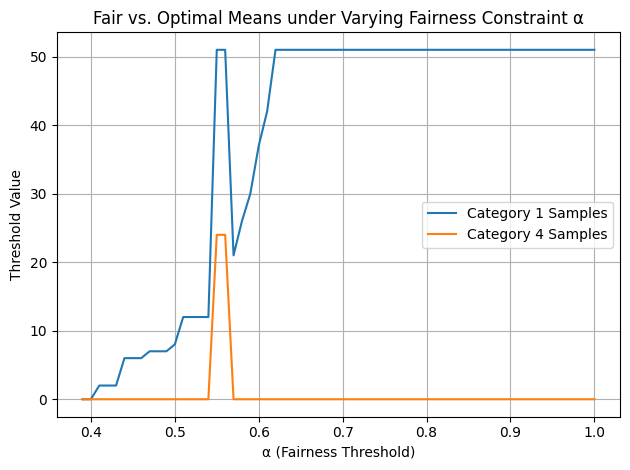

In [4]:
#plt.scatter(x_alphas, y_thresh_A, label="Fair Threshold (A)", color='orange')
#plt.plot(x_alphas, y_thresh_B, label="Fair Threshold (B)", color='purple')
"""plt.plot(x_alphas, y_pof)
plt.axhline(y_opt)
plt.plot(x_alphas, y_util)"""
plt.plot(x_alphas, y_cat_1, label='Category 1 Samples')
plt.plot(x_alphas, y_cat_4, label='Category 4 Samples')

plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
plt.xlabel("α (Fairness Threshold)")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plots
def plot_fairness(show_means=False, show_fair_thresholds=False, show_pof=False, show_utility=False, show_categories=False, show_plot2=False, alpha_idx=0):
    fig = plt.figure(figsize=(15, 6))

    if show_plot2: 
        ax1 = plt.subplot(1, 2, 1)
        ax2 = plt.subplot(1, 2, 2) 
        #plt.gcf().set_size_inches(12, 10)
        if alpha_idx < len(x_alphas):
            current_alpha = x_alphas[alpha_idx]
            util_cat1 = np.sum(expected(expected(y_samples_1[alpha_idx][1], c_plus, c_minus), u_plus, u_minus))
            util_cat4 = np.sum(expected(expected(y_samples_4[alpha_idx][1], c_plus, c_minus), u_plus, u_minus))
            if alpha_idx < len(y_samples_1):
                ax2.scatter(y_samples_1[alpha_idx][0], y_samples_1[alpha_idx][1], color='green', s=100, marker='D', 
                            label=f'Sample 1 (α={current_alpha:.2f})', zorder=5)
            if alpha_idx < len(y_samples_3):
                ax2.scatter(y_samples_3[alpha_idx][0], y_samples_3[alpha_idx][1], color='red', s=100, marker='D', 
                            label=f'Sample 3 (α={current_alpha:.2f})', zorder=5)
            if alpha_idx < len(y_samples_4):
                ax2.scatter(y_samples_4[alpha_idx][0], y_samples_4[alpha_idx][1], color='purple', s=100, marker='D', 
                            label=f'Sample 4 (α={current_alpha:.2f})', zorder=5)
        #ax2.annotate(f'Category 1 Util: {util_cat1:.2f}; Category 4 Util: {util_cat4:.2f}; sum of Util: {util_cat1 + util_cat4:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
        ax2.legend()
        ax2.set_title(f'Sample Distribution for α={current_alpha:.2f}')
    else:
        ax1 = plt.subplot(1, 1, 1) 

    if show_means:
        ax1.plot(0, mean_a, 'ro', label='Initial μ(A)')
        ax1.plot(0, mean_b, 'bo', label='Initial μ(B)')
        ax1.plot(x_alphas, y_mean_A, label="Fair μ(A)'", color='red')
        ax1.plot(x_alphas, y_mean_B, label="Fair μ(B)'", color='blue') 
    
    if show_fair_thresholds:
        ax1.scatter(x_alphas, y_thresh_A, label="Fair Threshold (A)", color='orange')
        ax1.scatter(x_alphas, y_thresh_B, label="Fair Threshold (B)", color='purple')
    
    if show_pof:
        ax1.scatter(x_alphas, y_pof, label='Price of Fairness', color='blue')
    
    if show_categories:
        ax1.plot(x_alphas, y_cat_1, label='# of Category 1', color='red', linestyle='--', marker='o')
        ax1.plot(x_alphas, y_cat_3, label='# of Category 2', color='darkgreen', linestyle='--', marker='^')
        ax1.plot(x_alphas, y_cat_4, label='# of Category 4', color='darkred', linestyle='--', marker='s')
    
    if show_utility:
        ax1b = ax1.twinx()
        ax1b.scatter(x_alphas, y_util, label='Total Utility', color='green', linewidth=2)
        ax1b.set_ylabel('Total Utility')
        ax1b.tick_params(axis='y', labelcolor='green')
        #ax1b.scatter(x_alphas, y_opt_util, label='Optimal Utility', color='black', linestyle='--', marker='^')
        
        # Combine legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1b.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    else:
        ax1.legend()

    ax1.set_xlabel("α (Fairness Threshold)")
    ax1.set_ylabel("Metric Value")
    ax1.grid(True) 
    ax1.set_title("Fair vs. Optimal Means under Varying Fairness Constraint α") 

    #plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
    plt.tight_layout()
    plt.show()

# Toggle widgets
means_toggle = widgets.Checkbox(value=False, description='Show Means')
fair_thresholds_toggle = widgets.Checkbox(value=False, description='Show Fair Thresholds')
pof_toggle = widgets.Checkbox(value=False, description='Show PoF')
utility_toggle = widgets.Checkbox(value=False, description='Show Utility')
categories_toggle = widgets.Checkbox(value=False, description='Show Categories')
plots_toggle = widgets.Checkbox(value=False, description='Show Plots')

alpha_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(alphas),
    step=1,
    description='α Index:',
    continuous_update=False,
    readout_format='d'
)

plus_button = widgets.Button(description='+')
minus_button = widgets.Button(description='-')

# Button click event handlers
def increase_value(b):
    if alpha_slider.value < alpha_slider.max:
        alpha_slider.value += alpha_slider.step

def decrease_value(b):
    if alpha_slider.value > alpha_slider.min:
        alpha_slider.value -= alpha_slider.step

plus_button.on_click(increase_value)
minus_button.on_click(decrease_value)

# Display everything together
display(widgets.HBox([minus_button, plus_button]))

ui = widgets.HBox([means_toggle, fair_thresholds_toggle, pof_toggle, utility_toggle, categories_toggle, plots_toggle, alpha_slider])
out = widgets.interactive_output(plot_fairness, {
    'show_means': means_toggle,
    'show_fair_thresholds': fair_thresholds_toggle,
    'show_pof': pof_toggle,
    'show_utility': utility_toggle,
    'show_categories': categories_toggle,
    'show_plot2': plots_toggle,
    'alpha_idx': alpha_slider,
})

display(ui, out)

Output()

In [114]:
rounded_vals = np.round(np.array(x_alphas), 2)
index = np.where(rounded_vals == 0.57)[0][0]
print(index)
print(y_util[index])
print(f'There are {y_cat_1[index]} category 1 samples for α=0.57')
print(f'There are {y_cat_4[index]} category 4 samples for α=0.57')
util_1 = np.sum(y_samples_1[index][1]) * w_a
util_4 = y_samples_4[index][1]
util_4 *= np.sum(util_4)
util_1 += np.sum(expected(B_temp, u_plus, u_minus)) * w_b
util_4 += opt_util_B * w_b
print(np.sum(util_1))
print(opt_util_B * w_b)
results = alt_fair_opt_step(a, b, u_plus, u_minus, c_plus, c_minus, x_alphas[index], domain, interval)
print(np.sum(expected(results[1], u_plus, u_minus)) * w_b)

18
-24.279535586548626
There are 9 category 1 samples for α=0.57
There are 0 category 4 samples for α=0.57
-4.512364540904754
-0.22553133091187816
-14.383383219769655


In [127]:
alpha = 0.51
greatest = -np.inf
results = alt_fair_opt_step(a, b, u_plus, u_minus, c_plus, c_minus, alpha, domain, interval)
temp_util = None
gamma = 1 

for i in np.arange(domain[1], domain[0], -interval):
    delta_A = expected(a, c_plus, c_minus)
    A = np.where(a > i, a + delta_A, a)
    diff = np.abs(np.mean(A) - np.mean(B_temp))
    if diff > alpha:
        print(f'Violation at threshold {round(i, 2)}')
        print(np.abs(alpha - diff))
        gamma = alpha / diff
    else:
        gamma = 1
    c1 = np.where((a > i) & (expected(a, u_plus, u_minus) >= 0) & (expected(a, c_plus, c_minus) >= 0))[0]
    c3 = np.where((a > i) & (expected(a, u_plus, u_minus) >= 0) & (expected(a, c_plus, c_minus) < 0))[0]
    c4 = np.where((a > i) & (expected(a, u_plus, u_minus) < 0) & (expected(a, c_plus, c_minus) < 0))[0]

    total = np.where(a > i)[0]
    temp_util = np.sum(w_a * expected(A, u_plus, u_minus) + expected(B_temp, u_plus, u_minus) * w_b)
    print(f'Threshold {round(i, 2)}: {temp_util} * {gamma} = {temp_util * gamma}')
    print(f'{len(total)}\\{len(c1)}\\{len(c3)}\\{len(c4)} \n' )

    greatest = max(greatest, temp_util * gamma)
    
print(f'Greatest Util: {greatest}')
#print(greatest)
#print(als)


Threshold 3.0: -27.20217589285288 * 1 = -27.20217589285288
0\0\0\0 

Threshold 2.9: -27.20217589285288 * 1 = -27.20217589285288
0\0\0\0 

Threshold 2.8: -27.20217589285288 * 1 = -27.20217589285288
0\0\0\0 

Threshold 2.7: -27.20217589285288 * 1 = -27.20217589285288
0\0\0\0 

Threshold 2.6: -27.164634815491112 * 1 = -27.164634815491112
2\2\0\0 

Threshold 2.5: -27.164634815491112 * 1 = -27.164634815491112
2\2\0\0 

Threshold 2.4: -27.164634815491112 * 1 = -27.164634815491112
2\2\0\0 

Threshold 2.3: -27.164634815491112 * 1 = -27.164634815491112
2\2\0\0 

Threshold 2.2: -27.144463737601452 * 1 = -27.144463737601452
3\3\0\0 

Violation at threshold 2.1
0.005087683198646831
Threshold 2.1: -27.08553482892201 * 0.9901226851959403 = -26.818002474780425
6\6\0\0 

Violation at threshold 2.0
0.00904998182982153
Threshold 2.0: -27.06771685203025 * 0.9825643345600026 = -26.59577319677367
7\7\0\0 

Violation at threshold 1.9
0.012524187048203128
Threshold 1.9: -27.051137764927006 * 0.97603137355429

In [ ]:
# Check if vectotized algorithm produces the same results as the original algorithm
results = alt_fair_opt_step(pop_A=a, pop_B=b, u_plus=1, u_minus=-1.1, c_plus=1, c_minus=-10, alpha=0.5, range_param=(-3, 3), size=0.05)
from utils import alt_fair_step
l = alt_fair_step(a, b, 1, -1.1, 1, -10, 0.5, (-3, 3), 0.05)

print(np.sum(results[0] + results[1]))
print(np.sum(l[0] + l[1]))


48.32876065466182
48.32876065466182


Threshold A: -1.4999999999999987
Threshold A: -1.3999999999999986
Threshold A: -1.2999999999999985
Threshold A: -1.1999999999999984
Threshold A: -1.0999999999999983
Threshold A: -0.9999999999999982
Threshold A: 0.8000000000000034


Text(0.5, 1.0, 'Threshold A with Fixed Threshold B vs Total Utility')

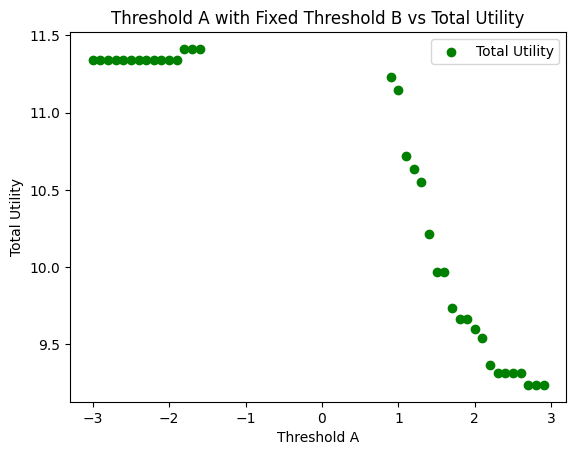

In [ ]:
### Experiment where alpha and the threshold of B is fixed while we vary the threshold of A

x_thresh_A = []
thresh_B = y_thresh_B[-1]
y_means_diff = []

from utils import expected
delta_A = expected(a, c_plus, c_minus)
delta_B = expected(b, c_plus, c_minus)

B = np.where(b > thresh_B, b + delta_B, b)
util_B = np.sum(expected(B, u_plus, u_minus))
util_A = []
max_A = None
max_util = None

c1 = []
c3 = []
c4 = []


thresholds = np.arange(domain[0], domain[1], interval)
for threshold in thresholds:
    alpha = 0.56
    A = np.where(a > threshold, a + delta_A, a)
    diff = np.abs(np.mean(A) - np.mean(B))
    if round(diff,2) == alpha:
        print("Threshold A:", threshold)
    y_means_diff.append(diff)
    utility = np.sum(expected(A, u_plus, u_minus))
    if max_util is None or utility > max_util:
        condition1 = (delta_A >= 0) & (expected(a, u_plus, u_minus) >= 0)
        condition2 = (delta_A >= 0) & (expected(a, u_plus, u_minus) < 0)
        condition3 = (delta_A < 0) & (expected(a, u_plus, u_minus) < 0)

        c1_indices = np.where(condition1)[0]
        c3_indices = np.where(condition2)[0]
        c4_indices = np.where(condition3)[0]

        c1 = [c1_indices, a[c1_indices] + expected(a, u_plus, u_minus)[c1_indices], ]
        c3 = [c3_indices, a[c3_indices] + expected(a, u_plus, u_minus)[c3_indices]]
        c4 = [c4_indices, a[c4_indices] + expected(a, u_plus, u_minus)[c4_indices]]

        max_util = utility
        max_A = A
    util_A.append(utility)
    x_thresh_A.append(threshold)

y_means_diff = np.array(y_means_diff)
x_thresh_A = np.array(x_thresh_A)

index = np.where(y_means_diff < alpha)[0]
x_util_thresh_A = x_thresh_A[index]
#x_util_thresh_A = x_thresh_A
w_a = len(a) / ( len(a) + len(b) )
w_b = 1 - w_a
total_util = w_a * np.array(util_A) + w_b * util_B
total_util = total_util[index]

plt.scatter(x_util_thresh_A, total_util, label='Total Utility', color='green')
plt.legend()
plt.xlabel("Threshold A")
plt.ylabel("Total Utility")
plt.title("Threshold A with Fixed Threshold B vs Total Utility")


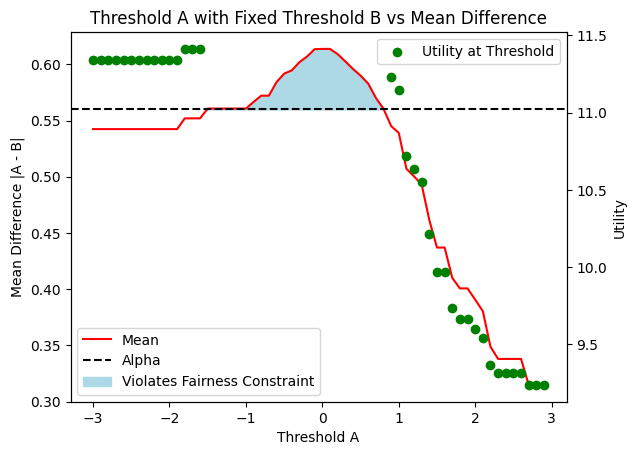

In [ ]:
### Experiment where the threshold of B is fixed while we track utility and difference in means

plt.plot(x_thresh_A, y_means_diff, label='Mean', color='red')
plt.axhline(y=alpha, label='Alpha', color='black', linestyle='--')
plt.fill_between(x_thresh_A, y_means_diff, alpha, where=(y_means_diff > alpha), color='lightblue', alpha=1, label='Violates Fairness Constraint')
plt.xlabel("Threshold A")
plt.ylabel("Mean Difference |A - B|")
plt.title("Threshold A with Fixed Threshold B vs Mean Difference")
plt.legend()

ax2 = plt.gca().twinx()
ax2.scatter(x_util_thresh_A, total_util, label='Utility at Threshold', color='green')
ax2.set_ylabel('Utility')
ax2.legend()

Text(0.5, 1.0, 'Distribution of A Before and After Policy')

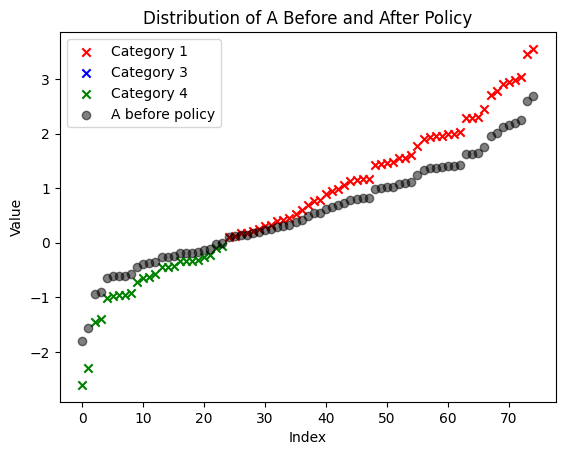

In [ ]:
a = np.array(a)
indices = np.arange(len(a))
plt.scatter(c1[0], c1[1], color='red', marker='x', label='Category 1')
plt.scatter(c3[0], c3[1], color='blue', marker='x', label='Category 3')
plt.scatter(c4[0], c4[1], color='green', marker='x', label='Category 4')


plt.scatter(indices, a, color='black', alpha=0.5, marker='o', label='A before policy')
#plt.scatter(indices, max_A, color='red', marker='x', label='A after policy')
#plt.axhline(y=-1.5, color='black', linestyle='--')
#plt.axhline(y=0.8, color='black', linestyle='--')
plt.legend()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Distribution of A Before and After Policy")

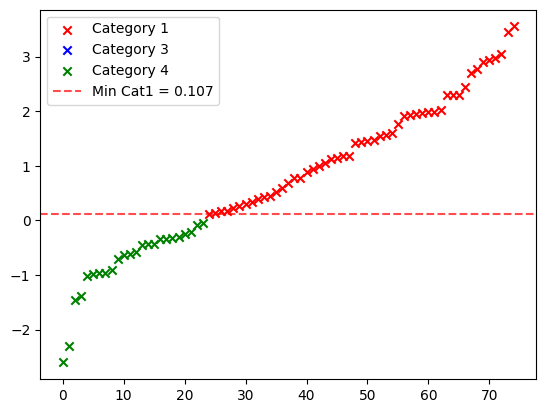

In [ ]:
# Define conditions
condition1 = (delta_A >= 0) & (expected(a, u_plus, u_minus) >= 0)
condition2 = (delta_A >= 0) & (expected(a, u_plus, u_minus) < 0)
condition3 = (delta_A < 0) & (expected(a, u_plus, u_minus) < 0)

# Get indices
cat1_ind = np.where(condition1)[0]
cat3_ind = np.where(condition2)[0]
cat4_ind = np.where(condition3)[0]

# Compute categories
cat1 = [cat1_ind, a[cat1_ind] + expected(a, u_plus, u_minus)[cat1_ind]]
cat3 = [cat3_ind, a[cat3_ind] + expected(a, u_plus, u_minus)[cat3_ind]]
cat4 = [cat4_ind, a[cat4_ind] + expected(a, u_plus, u_minus)[cat4_ind]]

# Plot
plt.scatter(cat1[0], cat1[1], color='red', marker='x', label='Category 1')
plt.scatter(cat3[0], cat3[1], color='blue', marker='x', label='Category 3')
plt.scatter(cat4[0], cat4[1], color='green', marker='x', label='Category 4')

# Draw line at smallest cat1 value
if len(cat1[1]) > 0:  # Check if cat1 has any points
    min_cat1_value = np.min(cat1[1])
    plt.axhline(y=min_cat1_value, color='red', linestyle='--', alpha=0.7, 
                label=f'Min Cat1 = {min_cat1_value:.3f}')

plt.legend()
plt.show()